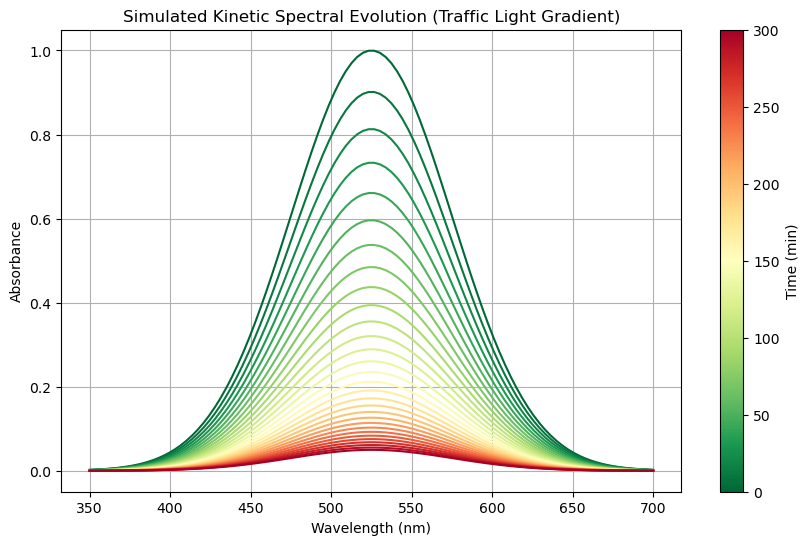

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Define base directory and file path
base_data_dir = os.path.expanduser("~/data")  
spectra_dir = os.path.join(base_data_dir, "spectra")  
os.makedirs(spectra_dir, exist_ok=True)  # Ensure directory exists

# Define the file path for saving
spec2_vis_csv_spectrapath = os.path.join(spectra_dir, "spec2_vis.csv")

# Define wavelength and time ranges
wavelengths = np.linspace(350, 700, 100)  # 100 wavelength points
times = np.linspace(0, 300, 30)  # 30 time points

# Simulate Absorbance Spectrum with a Boltzmann-like Shape Across Wavelengths
def generate_spectrum(wavelengths, peak_wavelength=525, width=50, max_absorbance=1.0):
    """Create a Gaussian peak across the wavelength range."""
    return max_absorbance * np.exp(-((wavelengths - peak_wavelength) ** 2) / (2 * width ** 2))

base_spectrum = generate_spectrum(wavelengths)

# Use exponential decay for time behavior
def kinetic_decay(time, t_half=100):
    """Exponential decay function"""
    return np.exp(-time / t_half)  # Corrected to true exponential decay
# Create a 2D Absorbance Array for (Wavelength, Time)
absorbance = np.outer(base_spectrum, kinetic_decay(times))

# Convert to Xarray Dataset
ds = xr.Dataset(
    data_vars={"absorbance": (["wavelength", "time"], absorbance)},
    coords={"wavelength": wavelengths, "time": times}
)

# **Use the correct colormap: "Red-Yellow-Green" (Reversed)**
cmap = plt.get_cmap("RdYlGn_r")  # Green → Yellow → Red
norm = plt.Normalize(vmin=times.min(), vmax=times.max())

# **Create figure**
fig, ax = plt.subplots(figsize=(10, 6))

# **Plot the evolving spectra using traffic light colors**
for i, time in enumerate(times):
    ax.plot(
        wavelengths, 
        ds.absorbance.sel(time=time), 
        color=cmap(norm(time)),  
        label=f"{int(time)} min" if int(time) % 100 == 0 else None
    )

# **Labels and title**
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorbance")
ax.set_title("Simulated Kinetic Spectral Evolution (Traffic Light Gradient)")
ax.grid(True)

# **Add a colorbar to show the time evolution properly**
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="Time (min)")

# **Show the plot**
plt.show()


In [2]:
import pandas as pd
import xarray as xr
import os
# Define base directory and file path
base_data_dir = os.path.expanduser("~/data")  
spectra_dir = os.path.join(base_data_dir, "spectra")  
os.makedirs(spectra_dir, exist_ok=True)  # Ensure directory exists

# Define the file path 
spec2_vis_csv_spectrapath = os.path.join(spectra_dir, "spec2_vis.csv")

# Define file path
file_path = spec2_vis_csv_spectrapath  # Replace with your actual file path

# Load CSV with the first row as the header
df_clean = pd.read_csv(file_path, header=0)

# Display the first few rows and column names for debugging
print(df_clean.head())
print(df_clean.columns)

# Rename columns to avoid confusion
df_clean.columns = ['Wavelength', 'Time', 'Absorbance']

# Convert 'Wavelength' and 'Time' columns to numeric values
df_clean['Wavelength'] = pd.to_numeric(df_clean['Wavelength'], errors='coerce')
df_clean['Time'] = pd.to_numeric(df_clean['Time'], errors='coerce')

# Drop rows with NaN values in 'Wavelength' or 'Time' columns
df_clean.dropna(subset=['Wavelength', 'Time'], inplace=True)


# Extract unique time values
time_values = df_clean['Time'].unique()

# Pivot the DataFrame to have 'Wavelength' as index and 'Time' as columns
df_pivot = df_clean.pivot(index='Wavelength', columns='Time', values='Absorbance')

# Convert the pivoted DataFrame to an xarray Dataset
ds_final = xr.Dataset(
    data_vars={'absorbance': (['wavelength', 'time'], df_pivot.values)},
    coords={'wavelength': df_pivot.index.values, 'time': df_pivot.columns.values}
)

# Display dataset summary
print(ds_final)


   wavelength       time  absorbance
0       350.0   0.000000    0.002187
1       350.0  10.344828    0.001973
2       350.0  20.689655    0.001779
3       350.0  31.034483    0.001604
4       350.0  41.379310    0.001446
Index(['wavelength', 'time', 'absorbance'], dtype='object')
<xarray.Dataset> Size: 25kB
Dimensions:     (wavelength: 100, time: 30)
Coordinates:
  * wavelength  (wavelength) float64 800B 350.0 353.5 357.1 ... 696.5 700.0
  * time        (time) float64 240B 0.0 10.34 20.69 31.03 ... 279.3 289.7 300.0
Data variables:
    absorbance  (wavelength, time) float64 24kB 0.002187 0.001973 ... 0.0001089


In [3]:
base_data_dir = os.path.expanduser("~/data")  
spectra_dir = os.path.join(base_data_dir, "spectra")  
os.makedirs(spectra_dir, exist_ok=True)  # Ensure directory exists

# Define the file path 
spec2_nc_spectrapath = os.path.join(spectra_dir, "spec2_vis.nc")
ds_final.to_netcdf(spec2_nc_spectrapath)

# Confirm that the file has been saved
if os.path.isfile(spec2_nc_spectrapath):
    print(f"Dataset successfully saved to: {spec2_nc_spectrapath}")
else:
    print("Failed to save the dataset.")

Dataset successfully saved to: /home/rebelford/data/spectra/spec2_vis.nc


In [4]:
import xarray as xr

# Define the path to your NetCDF file
file_path = spec2_nc_spectrapath  # Ensure this variable contains the correct path to 'cpec2_vis.nc'

# Open the NetCDF file and assign it to a new Dataset
new_ds = xr.open_dataset(file_path)

# Display the contents of the new Dataset
print(new_ds)


<xarray.Dataset> Size: 25kB
Dimensions:     (wavelength: 100, time: 30)
Coordinates:
  * wavelength  (wavelength) float64 800B 350.0 353.5 357.1 ... 696.5 700.0
  * time        (time) float64 240B 0.0 10.34 20.69 31.03 ... 279.3 289.7 300.0
Data variables:
    absorbance  (wavelength, time) float64 24kB ...


In [5]:
# Range of absorbance
absorbance_min = new_ds['absorbance'].min().item()
absorbance_max = new_ds['absorbance'].max().item()

# Range of wavelength
wavelength_min = new_ds['wavelength'].min().item()
wavelength_max = new_ds['wavelength'].max().item()

# Range of time
time_min = new_ds['time'].min().item()
time_max = new_ds['time'].max().item()

print(f"Absorbance: min = {absorbance_min}, max = {absorbance_max}")
print(f"Wavelength: min = {wavelength_min}, max = {wavelength_max}")
print(f"Time: min = {time_min}, max = {time_max}")


Absorbance: min = 0.000108908769855, max = 0.9993752590009782
Wavelength: min = 350.0, max = 700.0
Time: min = 0.0, max = 300.0


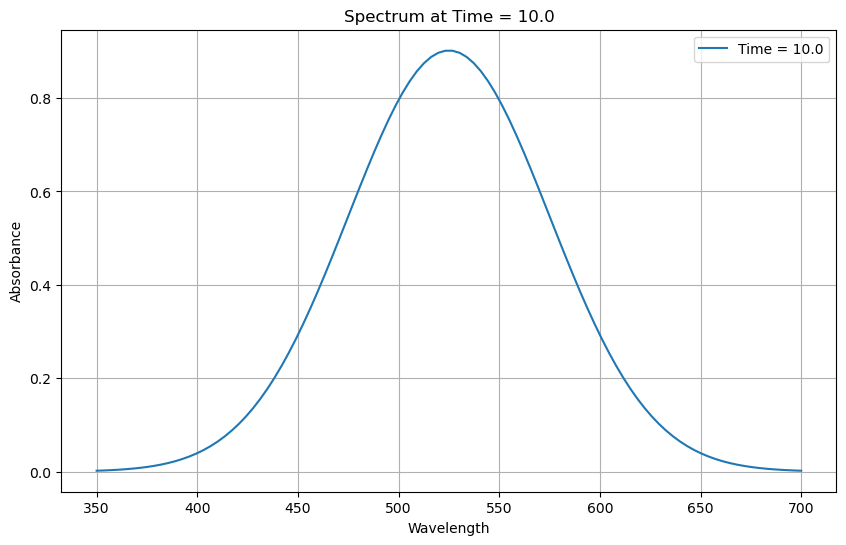

In [6]:
import matplotlib.pyplot as plt

# Specify the time for which to plot the spectrum
time_point = 10.0  # Replace with your desired time value

# Select the data at the specified time
spectrum = new_ds.sel(time=time_point, method='nearest')

# Plot the spectrum
plt.figure(figsize=(10, 6))
plt.plot(spectrum['wavelength'], spectrum['absorbance'], label=f'Time = {time_point}')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.title(f'Spectrum at Time = {time_point}')
plt.legend()
plt.grid(True)
plt.show()


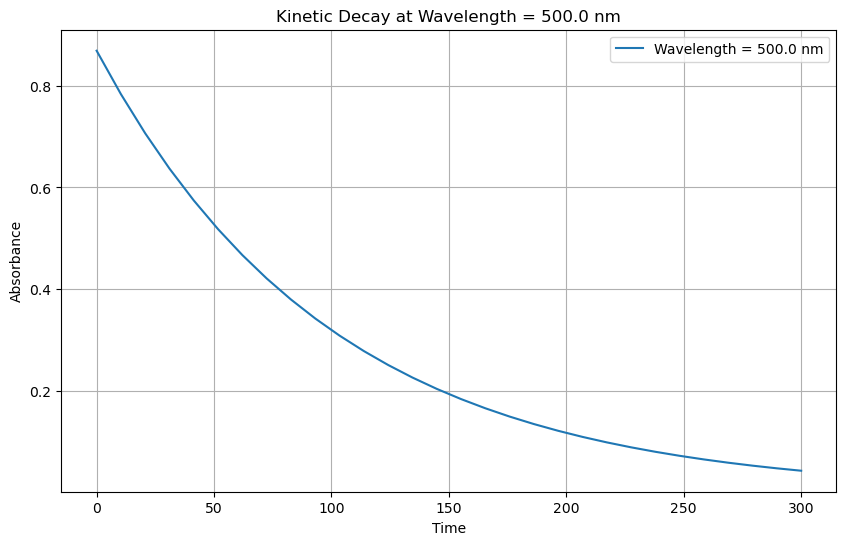

In [7]:
# Specify the wavelength for which to plot the kinetic decay
wavelength_point = 500.0  # Replace with your desired wavelength value

# Select the data at the specified wavelength
kinetic_decay = new_ds.sel(wavelength=wavelength_point, method='nearest')

# Plot the kinetic decay
plt.figure(figsize=(10, 6))
plt.plot(kinetic_decay['time'], kinetic_decay['absorbance'], label=f'Wavelength = {wavelength_point} nm')
plt.xlabel('Time')
plt.ylabel('Absorbance')
plt.title(f'Kinetic Decay at Wavelength = {wavelength_point} nm')
plt.legend()
plt.grid(True)
plt.show()
